In [44]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm,trange

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter('ignore')

In [45]:

def modified_mean_absolute_error(y_true, y_pred):
    "error_function"
    y_true=np.array(y_true).reshape(-1,) 
    y_pred=np.array(y_pred).reshape(-1,1)
    all_errors = []
    for i in range(y_pred.shape[0]):
        if y_pred[i] <= y_true[i]:
            all_errors.append(np.abs(y_true[i] - y_pred[i])*1.5)
        else:
            all_errors.append(np.abs(y_true[i] - y_pred[i]))
    return np.mean(all_errors)
            


# moving avg
def m_avg(stuff,window,min_period):
    "crete moving avarage from data, window,and min_period"
    moving_average = stuff.rolling( window=window,    
                                    center=True,      
                                    min_periods=min_period).mean()    
    return moving_average

# time dummy for trend
def dummy_features(stuff,order,out_steps):
    """returns time dummy features from data
        order:order_of time_dummy
        out_steps: forecast length
    """
    dp = DeterministicProcess(
        index=stuff.index,  
        constant=True,      
        order=order,        
        drop=True,)         
    return dp.in_sample(),dp.out_of_sample(steps=out_steps)


# periodogram
def plot_periodogram(ts, title,detrend='linear', ax=None):
    "plots periodogram for fourier features"
    
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="maroon")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title(title)
    return ax


def fourier_features(stuff,order,out_steps):
    """creates fourier features from data
        
    """
    fourier = CalendarFourier(freq="A", order=order)  
    dp = DeterministicProcess(
        index=stuff.index,
        constant=True,               # dummy feature for bias (y-intercept)
        order=1,                     # trend (order 1 means linear)
        seasonal=True,               # weekly seasonality (indicators)
        additional_terms=[fourier],  # annual seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )

    return dp.in_sample(),dp.out_of_sample(steps=out_steps)  


# functions

def make_lags(ts, lags, name,lead_time=1):
    "creates lag features for"
    
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)
    
    
def lag_for_cyclic(our_data):
    zero_row = pd.Series(dict(zip(our_data.columns, [0]*len(our_data.columns))))
    our_data = our_data.append(zero_row, ignore_index=True)
    
    y = our_data['aqi']
    aqi_lag_features  = make_lags(our_data['aqi'], lags=7,name='aqi').fillna(0.0)
    pm2_lag_features  = make_lags(our_data['pm2.5'], lags=3,name='pm2.5').fillna(0.0)
    pm10_lag_features = make_lags(our_data['pm10'], lags=3,name='pm10').fillna(0.0)
    o3_lag_features   = make_lags(our_data['o3'], lags=3,name='o3').fillna(0.0)
    co_lag_features   = make_lags(our_data['co'], lags=3,name='co').fillna(0.0)
    so2_lag_features  = make_lags(our_data['so2'], lags=3,name='so2').fillna(0.0)
    all_features=pd.concat([aqi_lag_features,pm2_lag_features,pm10_lag_features,o3_lag_features,co_lag_features,so2_lag_features],axis=1)
    return all_features.iloc[:-1],pd.DataFrame(all_features.iloc[-1]).transpose()


def time_series_split(data,n_split):
    """makes a time series split of a given data into n_splits"""
    tscv = TimeSeriesSplit(n_splits=n_split)
    train_test_indices = []
    for train_index, test_index in tscv.split(data):
        train_test_indices.append((train_index, test_index))
    return train_test_indices

# Data Fetching
-  Columns changed to lower case

-  Date,month,year columns added (not to use as features but just to look at the data in general)

-  Station id changed to an integer

-  Created station_id,state_code date columns crreated from id_date column for future use

In [46]:
data=pd.read_csv("train.csv")
data.columns=[i.lower() for i in data.columns]
data['date'] = data['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
data.sort_values('date',ascending=True,inplace=True)
data.reset_index(drop=True,inplace=True)
data['day']=data['date'].apply(lambda x: x.day)
data['month']=data['date'].apply(lambda x: x.month)
data['year']=data['date'].apply(lambda x: x.year)
data.stationid=pd.Series(map(int,data.stationid))

sample_sub=pd.read_csv("sample_submission.csv")
sample_sub['date']=sample_sub['ID_Date'].apply(lambda x: x.split('_')[-1])
sample_sub['stationid']=sample_sub['ID_Date'].apply(lambda x: int(x.split('_')[-2]))
sample_sub['statecode']=sample_sub['ID_Date'].apply(lambda x: x.split('_')[-3])
sample_sub['date'] = sample_sub['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())

states=data.statecode.unique()
state_info={i:data.loc[data['statecode']==i].stationid.unique() for i in states}

# Preprocessing

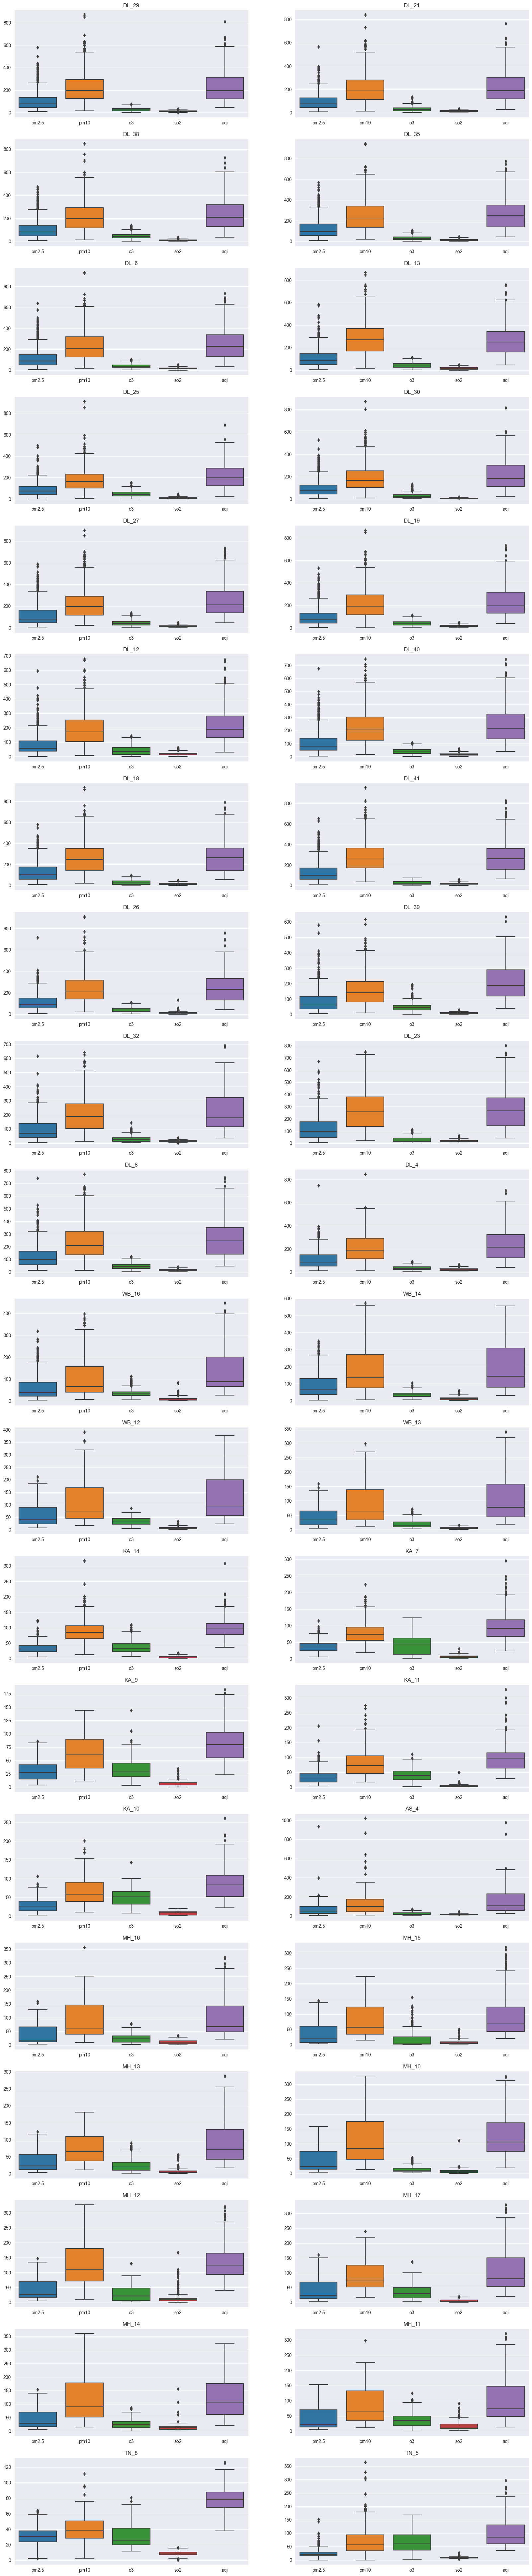

In [4]:
# looking at the boxplots before any preprocessing

sns.set_style('darkgrid')
fig, axs = plt.subplots(nrows=20, ncols=2, figsize=(20, 100))
cols = np.array([[0, 1] for i in range(20)]).reshape(-1,)
rows = np.array([np.array([0, 0])+i for i in range(20)]).reshape(-1,)

count = 0
for state in state_info.keys():
    for station in state_info[state]:
        point = data.loc[(data['statecode'] == state) & (data['stationid'] == station)]
        period_index = map(lambda x: pd.Period(x,freq='D'),point['date'])
        point.set_index(period_index,inplace=True)
        ax =axs[rows[count], cols[count]]
        sns.boxplot(point[['pm2.5','pm10','o3','so2','aqi']],ax=ax)
        ax.set_title(state+'_'+str(station));
        count += 1

In [47]:
data.groupby(['statecode']).mean()[['pm2.5','pm10','o3','co','so2','aqi']]

pm2.5        pm10         o3        co        so2         aqi
statecode                                                                    
AS          68.673807  125.605026  25.686966  0.774790  15.032071  150.309806
DL         109.444961  226.827221  37.457291  1.346106  14.730964  238.388854
KA          32.610387   75.320821  40.486084  0.907938   6.210320   91.252250
MH          39.869489   96.970733  26.632071  0.585328  10.681013  109.768269
TN          28.636210   60.779362  48.380022  0.799319   9.277744   90.245677
WB          65.368235  121.889471  32.293213  0.841527   9.229447  145.148833

- Except for o3 emission in delhi is pretty hight among others?

- State-station pair separate imputaion

- State and station wise standard scaling  (each scaling object stored in a dictionary for later inverse transforming)

- Dropped the NaN values

In [48]:
def remove_outliers(data, col_name):
    """IQR imputation on col_name in data"""
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return data[(data[col_name] >= lower_bound) & (data[col_name] <= upper_bound)]

for state in tqdm(state_info.keys(), total=len(state_info.keys())):
    for station in state_info[state]:
        data.loc[(data['statecode']==state)&(data['stationid']==station),'aqi'] = remove_outliers(data.loc[(data['statecode']==state)&(data['stationid']==station)], 'aqi')

sc_dict={}

for state in tqdm(state_info.keys(), total=len(state_info.keys())):
    for station in state_info[state]:
        sc_dict[state+'_'+str(station)]=StandardScaler()
        station_data=data.loc[(data['statecode']==state)&(data['stationid']==station),'aqi'].values.reshape(-1,1)
        data.loc[(data['statecode']==state)&(data['stationid']==station),'aqi'] = sc_dict[state+'_'+str(station)].fit_transform(station_data)

data.dropna(inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Trend
- Let's look at the moving average

- Moving average plotted with a window_size = 365 and period = 183  to avoid it from modelling potential yearly season in the data 

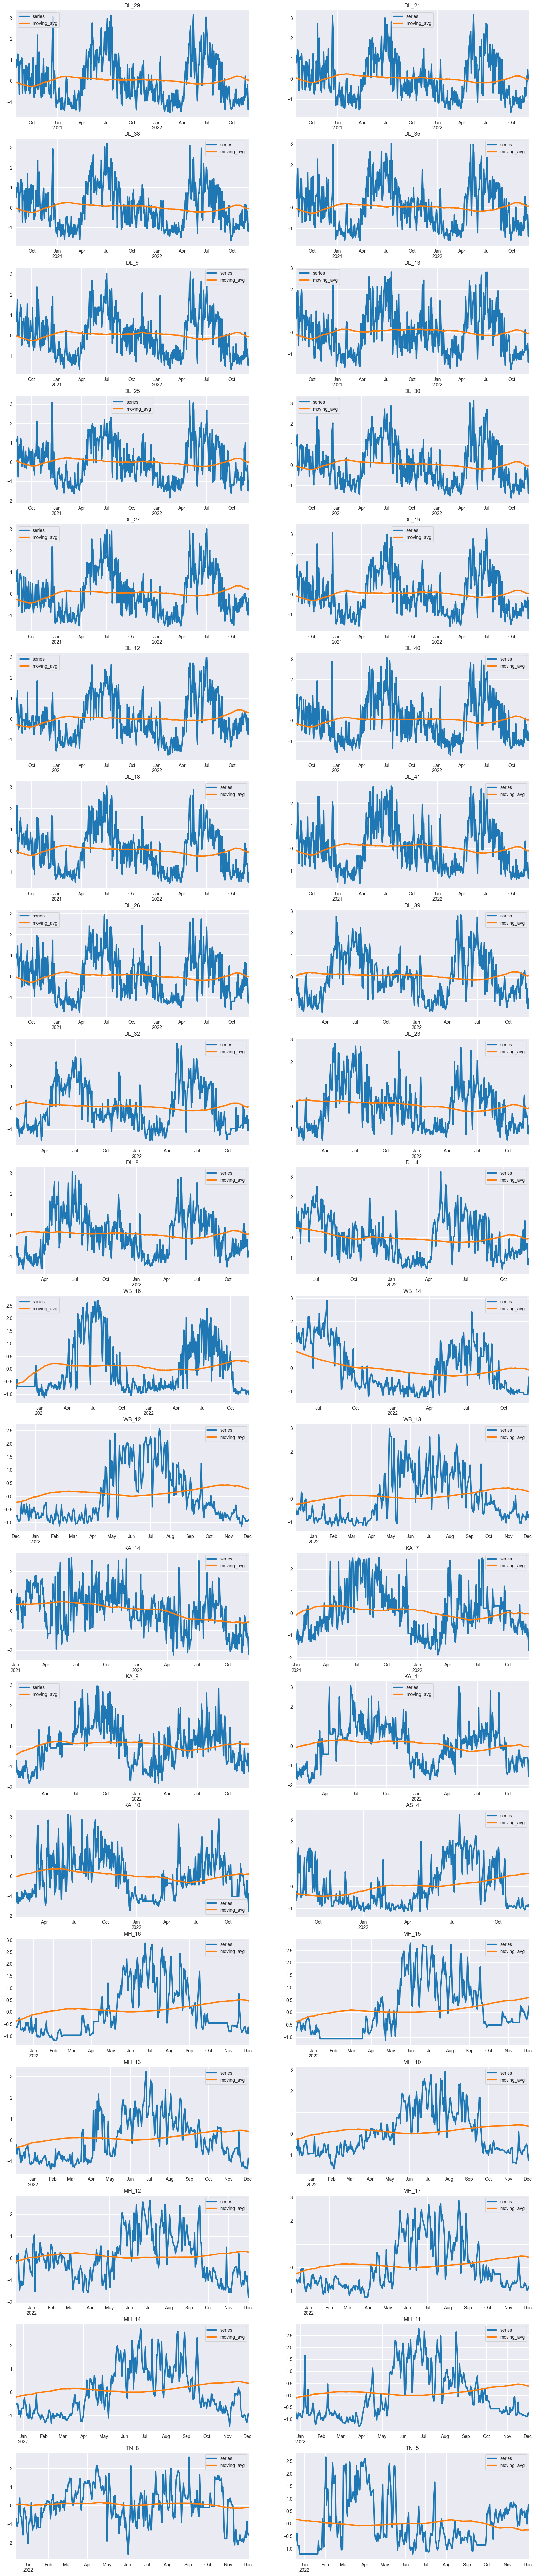

In [6]:
fig, axs = plt.subplots(nrows=20, ncols=2, figsize=(20, 100))
cols = np.array([[0, 1] for i in range(20)]).reshape(-1,)
rows = np.array([np.array([0, 0])+i for i in range(20)]).reshape(-1,)


count = 0
for state in state_info.keys():
    for station in state_info[state]:
        point = data.loc[(data['statecode'] == state) & (data['stationid'] == station)]
        period_index = map(lambda x: pd.Period(x,freq='D'),point['date'])
        point.set_index(period_index,inplace=True)
        ax =axs[rows[count], cols[count]]
        point['aqi'].plot(ax=ax, linewidth=3, title=state+'_'+str(station), legend=False);
        moving_average=m_avg(point['aqi'],365,183)
        moving_average.plot(ax=ax, linewidth=3, title="", legend=False);
        ax.legend(['series','moving_avg']);

        count += 1

plt.show()

- Most of these can be modelled by the first order **time dummy** except for some of them showing substantial 2nd or 3rd order kind of relationship with time (like wb_13)


- But before that i'm gonna define a 5-fold cross validate loop that would give you the loss output


- I will try to fit it with a Linear Regression model 

  0%|          | 0/6 [00:00<?, ?it/s]

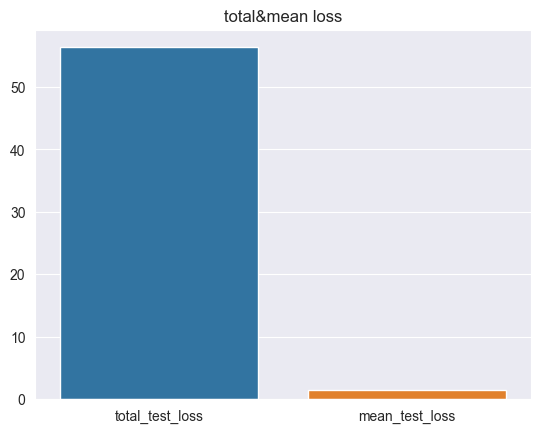

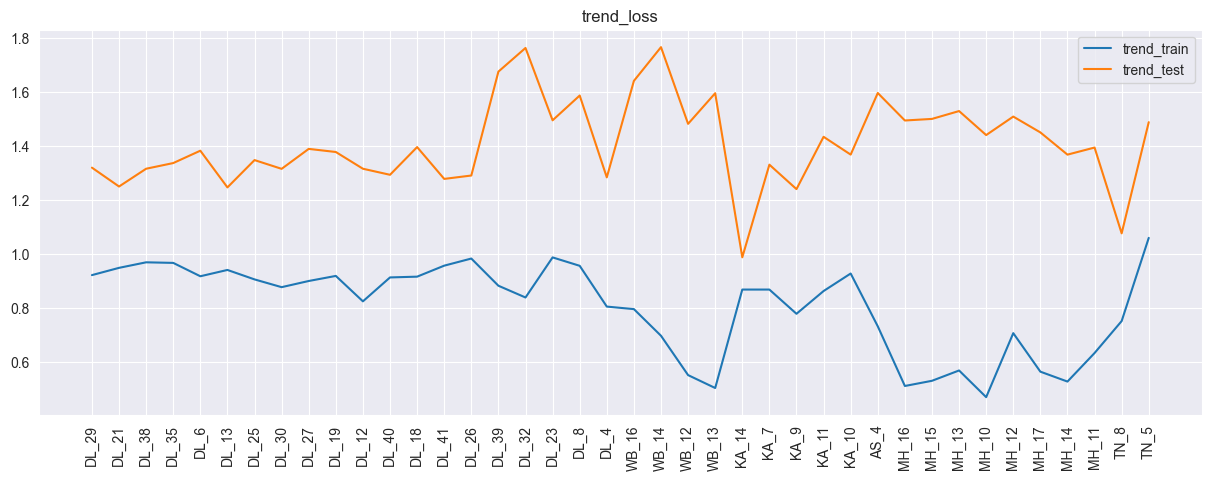

In [49]:
def trend_cross_val(data,trend_model):
    """cross val trend loss on data
        taking the trend model """
    data.reset_index(drop=True,inplace=True)
    period_index = map(lambda x: pd.Period(x,freq='D'),data['date'])
    data.set_index(period_index,inplace=True)
    train_losses=[]
    test_losses=[]
    trend_y=data['aqi']
    
    if state=='WB' and station==13:
        trend_in_sample,trend_out_sample=dummy_features(trend_y,order=2,out_steps=28)
    else:
        trend_in_sample,trend_out_sample=dummy_features(trend_y,order=1,out_steps=28)
    
    indices=time_series_split(data,n_split=5)
    for i,(train_index,test_index) in enumerate(indices):    
        train_trend_features= trend_in_sample.iloc[train_index]
        test_trend_features=trend_in_sample.iloc[test_index]
        trainy=trend_y.iloc[train_index]
        testy=trend_y.iloc[test_index]
        trend_model.fit(train_trend_features, trainy)
        trend_preds=pd.Series(trend_model.predict(train_trend_features), index=train_trend_features.index)
        trend_forecast=pd.Series(trend_model.predict(test_trend_features), index=test_trend_features.index)
     
        train_losses.append(modified_mean_absolute_error(trainy,trend_preds))
        test_losses.append(modified_mean_absolute_error(testy,trend_forecast))
    return np.mean(train_losses),np.mean(test_losses)



trend_model = LinearRegression(fit_intercept=False)  
trend_train_losses={}
trend_test_losses={}
for state in tqdm(state_info.keys(),total=6):
    for station in state_info[state]:
        data_ = data.loc[(data['statecode'] == state) & (data['stationid'] == station)]
        tr_l,ts_l=trend_cross_val(data_,trend_model)
        trend_train_losses[state+'_'+str(station)]=tr_l
        trend_test_losses[state+'_'+str(station)]=ts_l
        
        
sns.barplot(x=['total_test_loss','mean_test_loss'],y=[np.sum(list(trend_test_losses.values())),np.mean(list(trend_test_losses.values()))])
plt.title('total&mean loss');

plt.figure(figsize=(15,5))
plt.plot(trend_train_losses.keys(),trend_train_losses.values())
plt.plot(trend_test_losses.keys(),trend_test_losses.values())
plt.legend(['trend_train','trend_test'])
plt.xticks(rotation=90)
plt.title('trend_loss')
plt.show()

    

-  Now we can try arima and see if its working any better

## ARIMA

  0%|          | 0/6 [00:00<?, ?it/s]

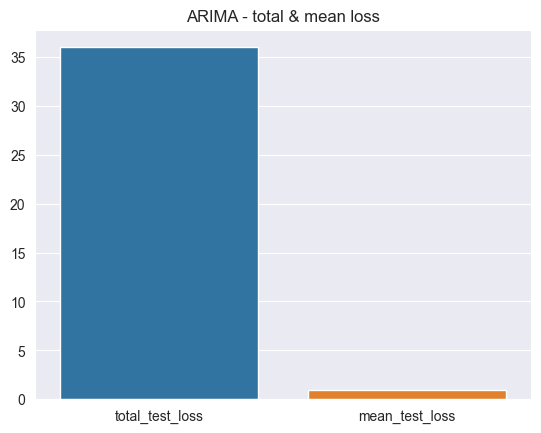

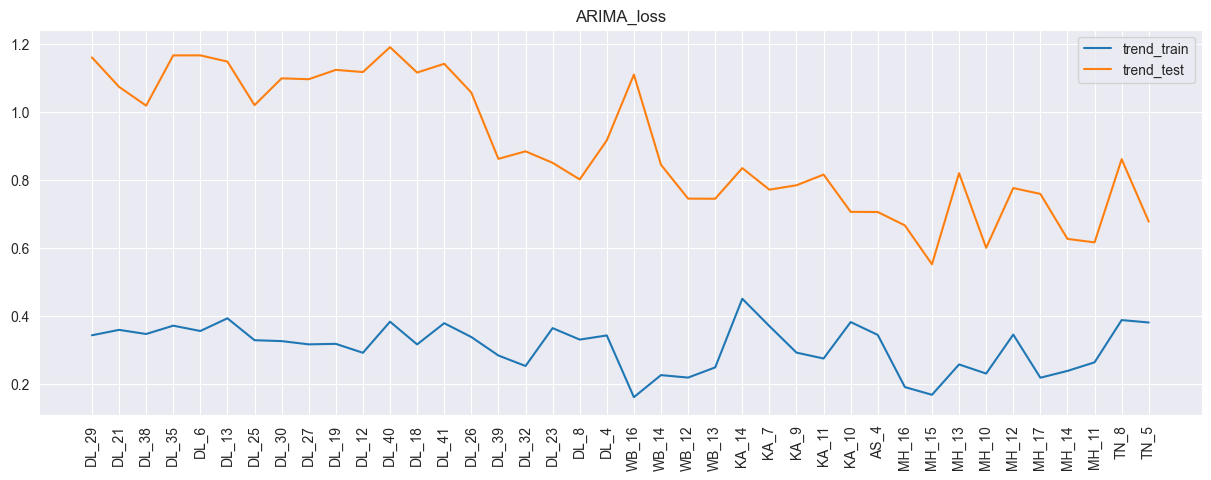

In [8]:
def arima_forecast(data,a_order,loss_test=False):
    data.reset_index(inplace=True,drop=True)
    data.dropna(axis=0,inplace=True)
    data.set_index('date',inplace=True)
    data_=data['aqi']
    
    train_loss=[]
    test_loss=[]
    if loss_test:
        "5-fold cross val score"
        indices=time_series_split(data_,n_split=5)
        for i,(train_index,test_index) in enumerate(indices):    
            train_trend_features= data_.iloc[train_index]
            test_trend_features=data_.iloc[test_index]
            model=ARIMA(endog=train_trend_features,order=a_order)
            model_fit=model.fit()
            trend_train_preds=model_fit.predict(start=0,end=len(train_trend_features)-1)
            trend_test_preds=model_fit.predict(start=len(train_trend_features),end=len(train_trend_features)+len(test_trend_features)-1)

            train_loss.append(mean_absolute_error(train_trend_features,trend_train_preds))
            test_loss.append(mean_absolute_error(test_trend_features,trend_test_preds))
       
        return np.mean(train_loss),np.mean(test_loss)
    
    elif loss_test==False:
        model=ARIMA(endog=data_,order=a_order)
        model_fit=model.fit()
        forecast=model_fit.forecast(steps=100)
        return forecast   
    
    
    
    
trend_train_losses={}
trend_test_losses={}

for state in tqdm(state_info.keys(),total=6):
    for station in state_info[state]:
        data_ = data.loc[(data['statecode'] == state) & (data['stationid'] == station)]
        tr_l,ts_l=arima_forecast(data_,a_order=(2,1,1), loss_test=True)
        trend_train_losses[state+'_'+str(station)]=tr_l
        trend_test_losses[state+'_'+str(station)]=ts_l
        
sns.barplot(x=['total_test_loss','mean_test_loss'],y=[np.sum(list(trend_test_losses.values())),np.mean(list(trend_test_losses.values()))])
plt.title('ARIMA - total & mean loss');

plt.figure(figsize=(15,5))
plt.plot(trend_train_losses.keys(),trend_train_losses.values())
plt.plot(trend_test_losses.keys(),trend_test_losses.values())
plt.legend(['trend_train','trend_test'])
plt.xticks(rotation=90)
plt.title('ARIMA_loss')
plt.show()

- ARIMA doing a pretty better job than our time dummy features

- also ARIMA of order (2,1,1) seems to have the best fit (i have tried other orders not shown here!)


- lets also look at how is the forecasting quality of arima (to what extend is it fitting trend/season of the data)

- lets use this arima to forecast last 100 "aqi" in each state-station pair

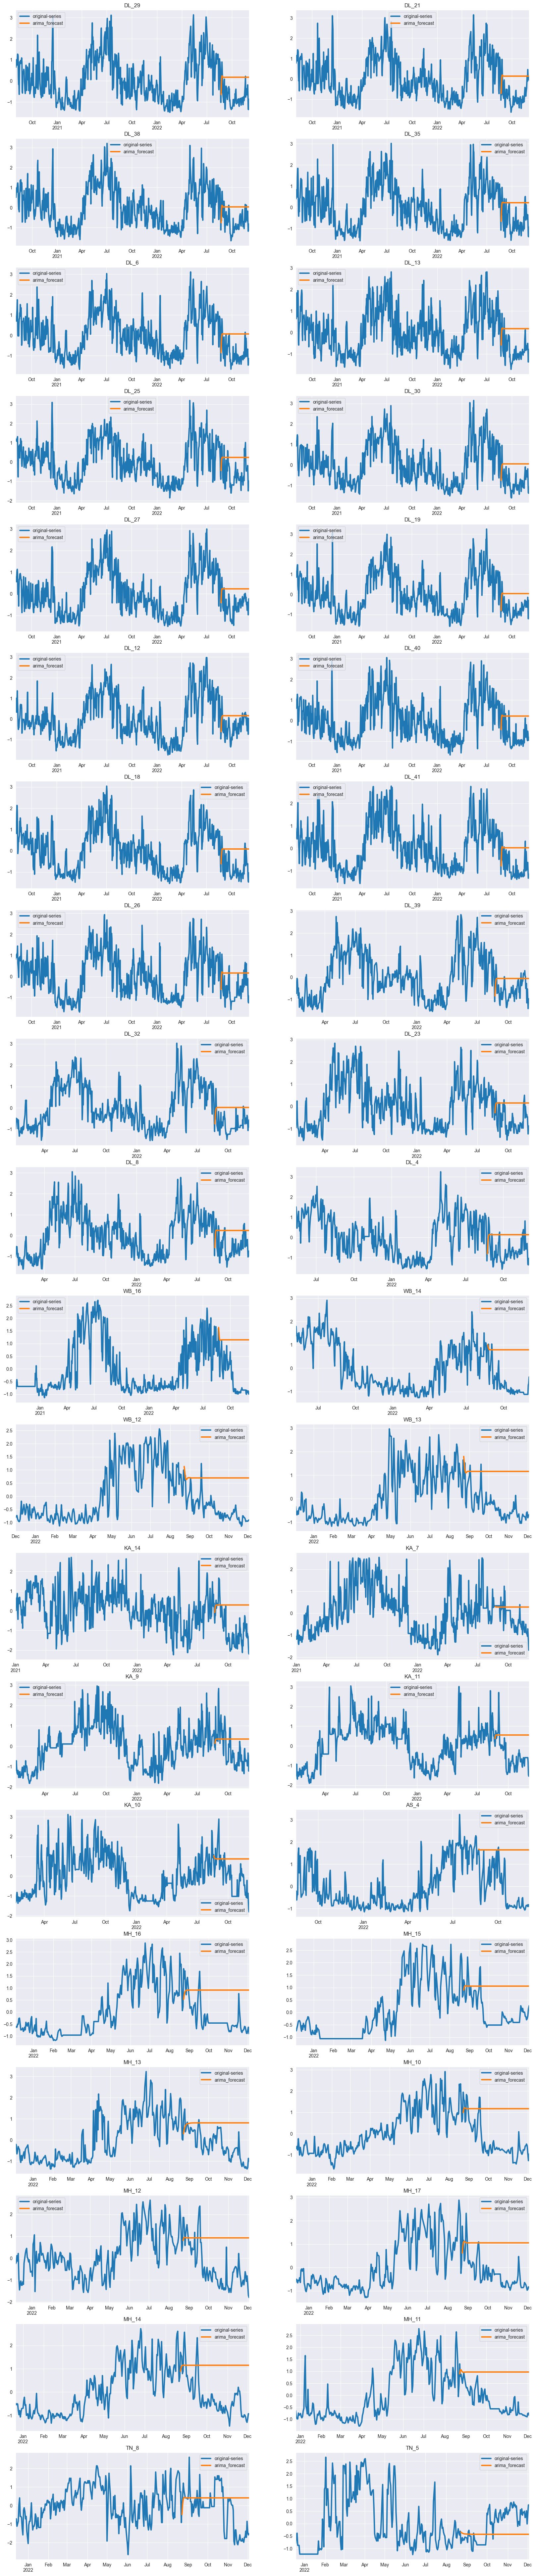

In [9]:
fig, axs = plt.subplots(nrows=20, ncols=2, figsize=(20, 100))
cols = np.array([[0, 1] for i in range(20)]).reshape(-1,)
rows = np.array([np.array([0, 0])+i for i in range(20)]).reshape(-1,)


count = 0
for state in state_info.keys():
    for station in state_info[state]:
        data_ = data.loc[(data['statecode'] == state) & (data['stationid'] == station)]
        period_index = map(lambda x: pd.Period(x,freq='D'),data_['date'])
        data_.set_index(period_index,inplace=True)
        ax =axs[rows[count], cols[count]]
        data_['aqi'].plot(ax=ax, linewidth=3, title=state+'_'+str(station), legend=False);
        arima_fore=arima_forecast(data_.iloc[:-100],a_order=(2,1,1), loss_test=False)
        pd.Series(arima_fore.values,index=data_.index[-100:]).plot(ax=ax, linewidth=3, title=state+'_'+str(station), legend=False);
        ax.legend(['original-series','arima_forecast']);
        count += 1
plt.show()

- ARIMA is taking care of the trend better


- We will select ARIMA for modeling the trend


- Now we'll try to do model the season

# Season

- First we will plot the periodogram and see what features we need to create

- We are majorly going to make fourier features

- If there are weekly seasons thn we will try to add indicators

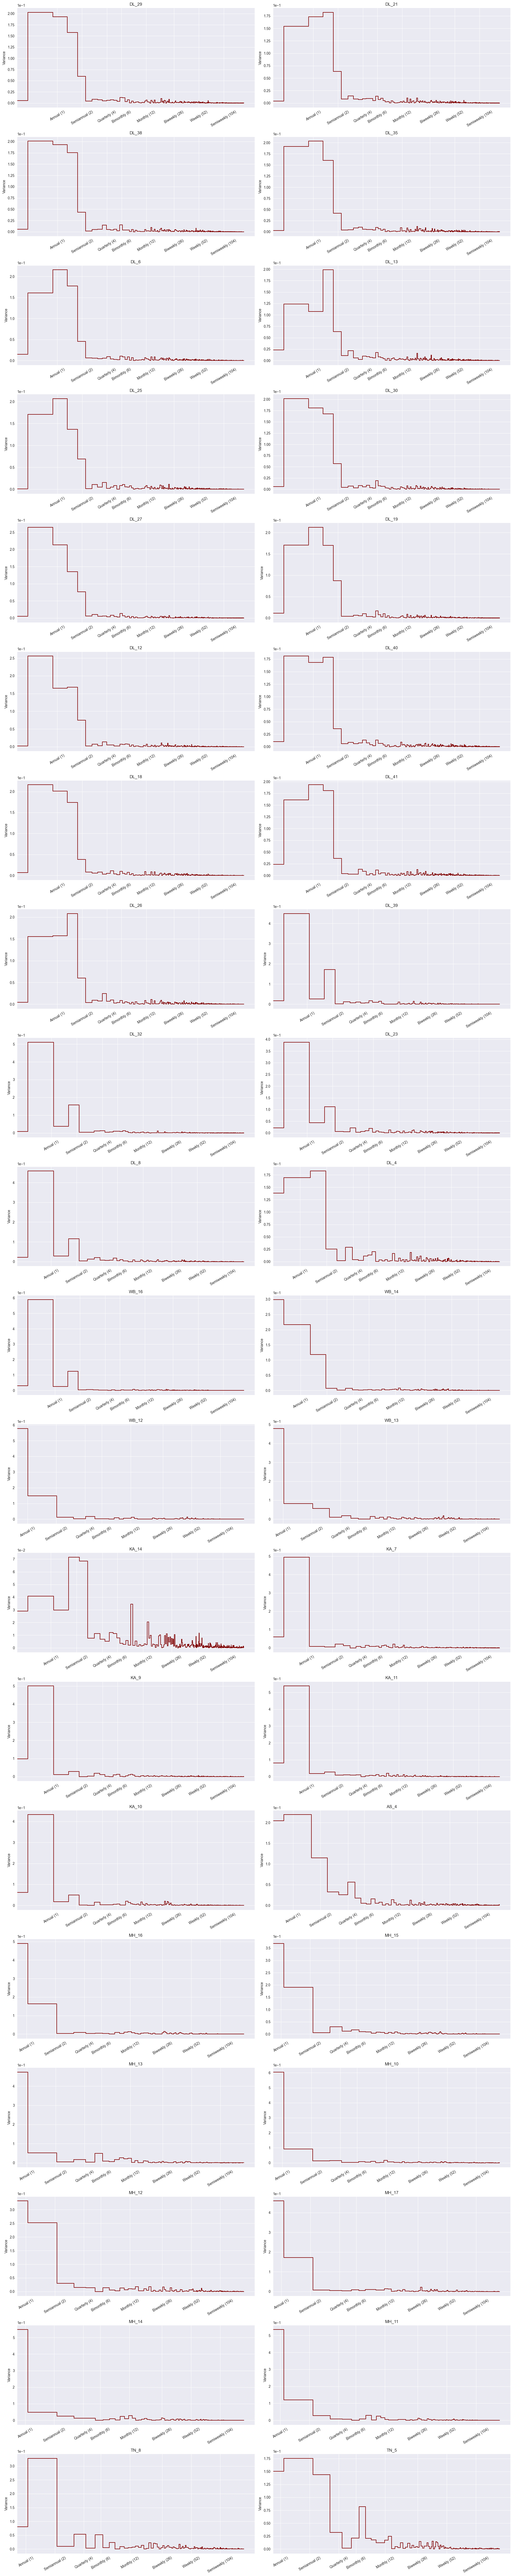

In [10]:
fig, axs = plt.subplots(nrows=20, ncols=2, figsize=(20, 100))
cols = np.array([[0, 1] for i in range(20)]).reshape(-1,)
rows = np.array([np.array([0, 0])+i for i in range(20)]).reshape(-1,)


count = 0
for state in state_info.keys():
    for station in state_info[state]:
        data_ = data.loc[(data['statecode'] == state) & (data['stationid'] == station)]
        period_index = map(lambda x: pd.Period(x,freq='D'),data_['date'])
        data_.set_index(period_index,inplace=True)
        ax =axs[rows[count], cols[count]]
        plot_periodogram(data_['aqi'],title=state+'_'+str(station),ax=ax)
        plt.tight_layout()
        count += 1
plt.show()

In [50]:
# handpicked features through multiple trial and error

season_dict={state:{station:0 for station in state_info[state]} for state in  state_info.keys()}

season_dict['DL'][29]=5
season_dict['DL'][21]=5
season_dict['DL'][38]=5
season_dict['DL'][35]=5
season_dict['DL'][6]=5
season_dict['DL'][13]=5
season_dict['DL'][25]=4
season_dict['DL'][30]=4
season_dict['DL'][27]=5
season_dict['DL'][19]=4
season_dict['DL'][12]=5
season_dict['DL'][40]=5
season_dict['DL'][18]=5
season_dict['DL'][41]=5
season_dict['DL'][26]=5
season_dict['DL'][39]=5
season_dict['DL'][32]=5
season_dict['DL'][23]=5
season_dict['DL'][8]=5
season_dict['DL'][4]=5

season_dict['WB'][16]=1
season_dict['WB'][14]=2
season_dict['WB'][12]=4
season_dict['WB'][13]=4

season_dict['KA'][14]=12
season_dict['KA'][7]=2
season_dict['KA'][9]=2
season_dict['KA'][11]=1
season_dict['KA'][10]=2

season_dict['AS'][4]=12

season_dict['MH'][16]=2
season_dict['MH'][15]=7
season_dict['MH'][13]=10
season_dict['MH'][10]=3
season_dict['MH'][12]=10
season_dict['MH'][17]=11
season_dict['MH'][14]=14
season_dict['MH'][11]=8

season_dict['TN'][8]=14
season_dict['TN'][5]=16

- The fourier_features produce features for in_sample data and also for out_of_sample data for the next 28 days. which is what we are going to base our predictions on


- Now I can make a 5- fold cross validate loop 

- Here I first model the trend (trend model if fixed - ARIMA (2,1,1) - since it performed well for trend)

- Then fit the season features(fourier features) on the residue using random forest regressor

- Finally add both predictions together

- I will output mean cross valid loss(loss=mmae) 

- This steps is performed for each state station pair of data

- So, i am modelling one final model(arima+random forest) for the entire data (all state-station pairs)

- The sum of the cross valid loss from each separate station is what i intent to reduce

In [59]:
def trend_season_cross_val(data,season_model):
    
    """return cross val train,test loss on data 
        also takes a season model"""
    data.reset_index(drop=True,inplace=True)
    period_index = map(lambda x: pd.Period(x,freq='D'),data['date'])
    data.set_index(period_index,inplace=True)
    ts=data['aqi']
    train_losses=[]
    test_losses=[]
    abs_diff=[]
    
    trend_in_sample=ts    
    state=data['statecode'][0]
    station=data['stationid'][0]
    fou=season_dict[state][station]
    season_in_sample,season_out_sample=fourier_features(ts,fou,28)
   
    indices=time_series_split(data,n_split=5)
    for i,(train_index,test_index) in enumerate(indices):    

        train_trend_features= trend_in_sample.iloc[train_index]
        test_trend_features=trend_in_sample.iloc[test_index]
        trainy=ts.iloc[train_index]
        testy=ts.iloc[test_index]

        trend_model=ARIMA(train_trend_features,order=(2,1,1))
        model_fit=trend_model.fit()
        trend_pred_y=model_fit.predict(start=train_trend_features.index[0],end=train_trend_features.index[-1])
        trend_forecast=model_fit.forecast(steps=len(test_trend_features))
        residue=train_trend_features-trend_pred_y
        
        train_season_features=season_in_sample.iloc[train_index]
        test_season_features=season_in_sample.iloc[test_index]
        
        season_model.fit(train_season_features,residue)
        season_pred_y=season_model.predict(train_season_features)
        season_forecast=season_model.predict(test_season_features)
        
        total_forecast=trend_forecast+season_forecast
        total_pred_y=trend_pred_y+season_pred_y
        
        test_losses.append(modified_mean_absolute_error(testy,total_forecast))
        train_losses.append(modified_mean_absolute_error(trainy,total_pred_y))
        abs_diff.append(np.mean(testy-total_forecast))
    return np.mean(train_losses),np.mean(test_losses),np.mean(abs_diff)

# Optimization

- I will try fitting a RandomForestRegressor on the season data fixing the trend model as  ARIMA(2,1,1)

- A grid search on a variety of parameters on wandb sweeps

In [ ]:
import wandb

sweep_config={'method':'grid'}
metric={'name':'loss',
        'goal':'minimize'
       }
sweep_config['metric']=metric
parameters_dict={
    "n_estimators":{'values':[50, 100, 150]},
    "max_depth": {'values':[5, 10, 15]},
    "min_samples_split": {'values':[2, 4, 6]},
    "min_samples_leaf": {'values':[1, 2, 4]},
    "random_state": {'values':[42]},
    "max_features": {'values':["auto", "sqrt", "log2"]},
    "bootstrap": {'values':[True, False]},
}

sweep_config['parameters']=parameters_dict
sweep_id=wandb.sweep(sweep_config,project='random_forest')

def train(config=None):
    with wandb.init(config=config):
        config=wandb.config
        season_model=RandomForestRegressor(n_estimators=config.n_estimators,
                                           max_depth=config.max_depth,
                                           min_samples_split=config.min_samples_split,
                                           min_samples_leaf=config.min_samples_leaf,
                                           random_state=config.random_state,
                                           max_features=config.max_features,
                                           bootstrap=config.bootstrap,
                                           )
        train_losses={}
        test_losses={}
        for state in tqdm(state_info.keys(),total=6):
            for station in state_info[state]:
                data_=data.loc[(data['statecode']==state)&(data['stationid']==station)]
                train_l,test_l,_=trend_season_cross_val(data_,season_model)
                train_losses[state+'_'+str(station)]=train_l
                test_losses[state+'_'+str(station)]=test_l
        
        wandb.log({'loss':np.sum(list(test_losses.values()))})
        wandb.log({'train_loss':np.sum(list(train_losses.values()))})

model_state=wandb.agent(sweep_id,train,count=10)

# Best Model

- Here get the best hyper parameter configuration from the sweep

In [14]:
project_name='random_forest'
runs = wandb.Api().runs(project_name)
runs = sorted(runs, key=lambda r: r.summary.get("loss", float('inf')))
best_run = runs[0]
hyperparams = best_run.config

In [53]:
# running optimization produces these hyperparams

hyperparams={'bootstrap': True,
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 150,
 'random_state': 42,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

# Testing 

- Here the new model is tested on the 5 fold cross valid loop and we will see how it performs on each station data (but we optimized the total loss across all stations)

In [60]:
season_model=RandomForestRegressor(**hyperparams)
train_losses={}
test_losses={}
mean_absolute_diff={} #(real-pred)mean

for state in tqdm(state_info.keys(),total=6):
    for station in state_info[state]:
        data_=data.loc[(data['statecode']==state)&(data['stationid']==station)]
        train_l,test_l,abs_diff=trend_season_cross_val(data_,season_model=season_model)
        train_losses[state+'_'+str(station)]=train_l
        test_losses[state+'_'+str(station)]=test_l
        mean_absolute_diff[state+'_'+str(station)]=abs_diff

  0%|          | 0/6 [00:00<?, ?it/s]

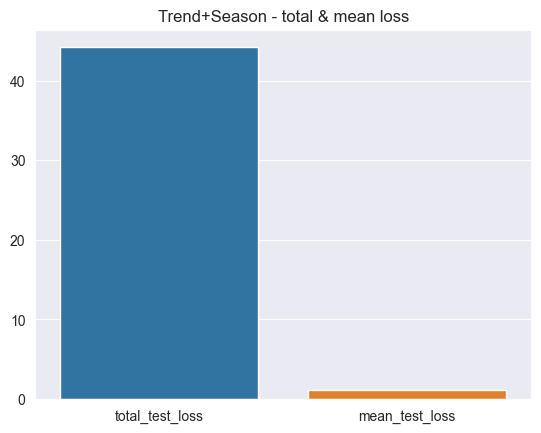

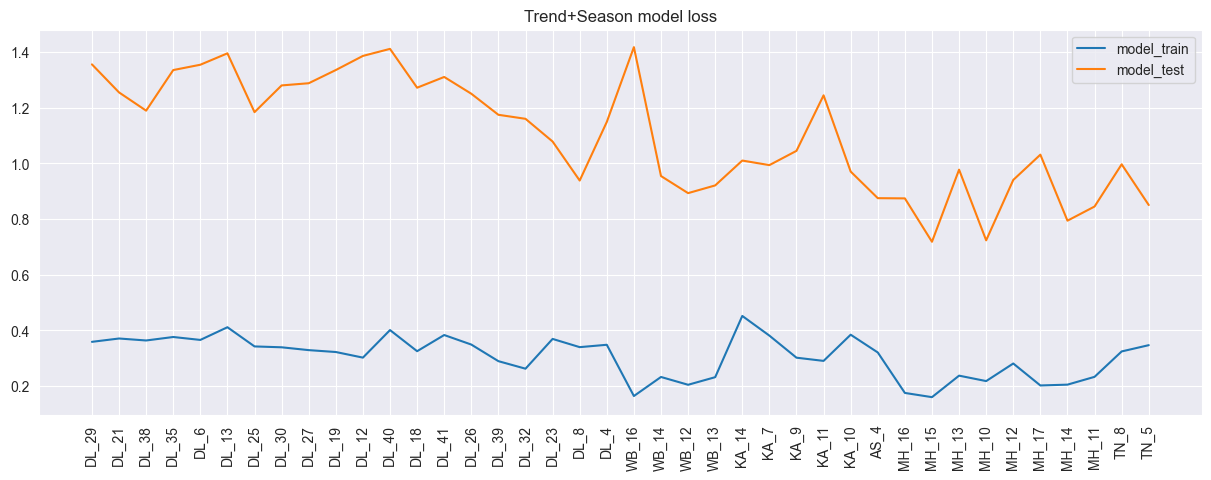

In [61]:
sns.barplot(x=['total_test_loss','mean_test_loss'],y=[np.sum(list(test_losses.values())),np.mean(list(test_losses.values()))])
plt.title('Trend+Season - total & mean loss');

sns.set_style('darkgrid')
plt.figure(figsize=(15,5))
plt.plot(train_losses.keys(),train_losses.values())
plt.plot(test_losses.keys(),test_losses.values())
plt.legend(['model_train','model_test'])
plt.xticks(rotation=90)
plt.title('Trend+Season model loss')
plt.show()

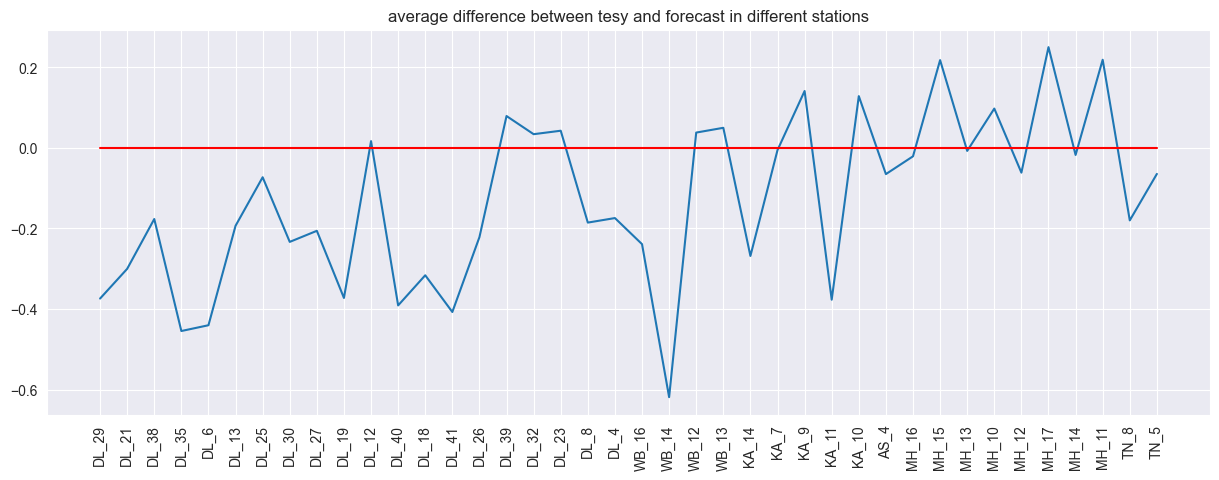

In [70]:
plt.figure(figsize=(15,5))
plt.plot(mean_absolute_diff.keys(),mean_absolute_diff.values())
plt.plot(mean_absolute_diff.keys(),[0 for i in range(40)],color='red')
plt.xticks(rotation=90)
plt.title('average difference between tesy and forecast in different stations')
plt.show()

# Business Impacts

- Stations with below zero value in the above graph makes avg prediction bigger than the real value

- Stations with above zero value produces predictions lesser than the rel value

- So in Karnataka, Maharashtra and Tamil Nadu despite having better prediction, predictions are going to forecast a better air quality but in reality Its not

- But mostly in Delhi and some West Bangal stations the model forecast is going to show poor air quality but in reality it's way better

- But result wise Maharashtra and Tamilnadu is going to be closer to real AQI (where its by far the best to implement)

- On the other hand using this model for forecasting AQI in Delhi must not be the best idea (results can be improved incorporating lag features on other emissions so2, co,pm10 etc for modeling cycles or even modeling stations in delhi separately) - but including  cylic features wasn't the best pipeline for me (we might require to incorporate other intricacies)

# Submission

- Now we will train on the in data sample and test on out_of_samples(next 28 days) we created

- Finally we inverse transform our predictions using the scaling objects we saved previously 

In [67]:
season_model=RandomForestRegressor(**{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 150,
 'random_state': 42,
 'min_samples_leaf': 1,
 'min_samples_split': 2})

for state in tqdm(state_info.keys(),total=6):
    for station in state_info[state]:
        name=state+'_'+str(station)
        data_=data.loc[(data['statecode']==state)&(data['stationid']==station)]
        data_.reset_index(drop=True,inplace=True)
        period_index = map(lambda x: pd.Period(x,freq='D'),data_['date'])
        data_.set_index(period_index,inplace=True)
        ts=data_['aqi']
        trend_in_sample=ts    
        state=data_['statecode'][0]
        station=data_['stationid'][0]
        fou=season_dict[state][station]
        season_in_sample,season_out_sample=fourier_features(ts,fou,28)
        
        trend_model=ARIMA(ts,order=(2,1,1))
        model_fit=trend_model.fit()
        pred_y=model_fit.predict(start=ts.index[0],end=ts.index[-1])
        forecast_1=model_fit.forecast(steps=28)
        residue=ts-pred_y
        
        season_model.fit(season_in_sample,residue)
        pred_y_=season_model.predict(season_in_sample)
        forecast_2=season_model.predict(season_out_sample)
        forecast=forecast_1+forecast_2
        
        try:
            forecast_sc=sc_dict[name].inverse_transform(forecast.values.reshape(-1,1))
        except:
            forecast_sc=sc_dict[name].inverse_transform(forecast.reshape(-1,1))
            
        sample_sub.loc[(sample_sub['statecode']==state)&(sample_sub['stationid']==station), 'AQI'] = forecast_sc

sample_sub.drop(['date','stationid','statecode'],axis=1,inplace=True)
sample_sub.to_csv('submission.csv',index=False,header=True)        

  0%|          | 0/6 [00:00<?, ?it/s]